In [247]:
file_path = r"C:\Users\samha\Documents\CANVAS\data"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import fmin
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

%matplotlib qt
%matplotlib inline

data = pd.read_csv(file_path + r'/data_sample_2.csv', index_col = 0)
data.sort_index(inplace=True)
data.index = pd.to_datetime(data.index)

data['unix_ts'] = data.index.astype(int) / 10**9
data['x_fit'] = (data['unix_ts'] - data['unix_ts'][0])/60 #this is necessary for the fitting purpose since the precision is broken if we use alarge number.

In [248]:
# ================== Global parameters for fonts & sizes =================
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': font_size, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

In [249]:
def filter_sunrise_sunset(df):
    """Filter a D-PV Time series data based on its estimated sunrise and sunset time.

    Args:
    df (df): D-PV Time series data

    Returns:
    sunrise (timestamp): estimated sunrise time (when power is >10 W for the first time in a day)
    sunset (timestamp): the opened ghi data (when power is >10 W for the last time in a day)
    df (df): filtered D-PV Time series data
    """
    if df is None or len(df.index) == 0:
        return None

    tmpDF = df.loc[df['power'] > 10]
    if len(tmpDF.index) == 0:
        return None

    sunrise = tmpDF.index[0]
    sunset = tmpDF.index[-1]

    df = df.loc[df.index > sunrise]
    df = df.loc[df.index < sunset]

    return sunrise, sunset, df

def filter_curtailment(df):
    """Take the power data and row number from D-PV time-series data & filter out curtailment. Will be used for polyfit regression.

    Args:
    df (df): Time-series D-PV data with power column and timestamp as an index

    Returns:
    powerArray (pd series): filtered power data
    timeArray (pd datetime): filtered row number data
    """
    
    maxDailyPower = max(df.power)
    if len(df.loc[df['power'] == maxDailyPower].index) > 1:
        return None, None
    
    filter_first_half = []
    filter_second_half = []
    powerArray = df.power
    xArray = df['x_fit']
    
    halfFlag = True  # True is first half, False is second half
    last_highest_power = 0
    
    for power in powerArray:

        # IF power IS GREATER THAN last_highest_power THEN INCLUDE power AND INCREASE last_highest_power
        if power > last_highest_power:
            last_highest_power = power
            filter_first_half.append(True)
        else:
            filter_first_half.append(False)

        if power == maxDailyPower:
            break
            
    last_highest_power = 0
    
    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for power in powerArray.iloc[::-1]:

        if power == maxDailyPower:
            break

        if power > last_highest_power:
            last_highest_power = power
            filter_second_half.append(True)
        else:
            filter_second_half.append(False)
            
    # COMBINE TO FILTERED SIDES
    filter_second_half.reverse()
    filterArray = filter_first_half + filter_second_half
    return xArray[filterArray], powerArray[filterArray]

In [ ]:
def func(a,x):
    """Calculate the result of a quadratic function

    Args:
    a (nd array of dimension 3x1) : a[0] is coefficient of x^2, a[1] is coefficient of x, a[2] is the constant
    x (nd array of dimension nx1) : matrix of x value that will be plugged into the function, n is the number of x values

    Returns:
    y (nd array of dimension nx1) : matrix of result value, n is the number of y values
    """
    y = a[0] * x**2 + a[1] * x + a[2]
    return y

def sum_squared_error(a):
    """Calculate the sum of the square error of the fitting result and the actual value

    Args:
    a (nd array of dimension 3x1) : a[0] is coefficient of x^2, a[1] is coefficient of x, a[2] is the constant
    
    Returns:
    sum_squared_error (float) : a single value of sum squared error. This will be used for the objective value that we
                                want to minimize for the fitting process.
    """
    
    y_fit = func(a,x_for_fitting) #x_for fitting here is a global variable so must be defined before declaring the function.
    sum_squared_error = sum((y_fit - y)**2)
    return sum_squared_error

In [250]:
def check_polyfit_constrained(data):
    sunrise, sunset, data = filter_sunrise_sunset(data)

    x, y = filter_curtailment(data)
    x_for_fitting = np.array(x)
    y_for_fitting = np.array(y)

    #Set the constraint: the polyfit result - actual power >= 0
    con_func_1 = lambda x: func(a = x, x = x_for_fitting) - y_for_fitting
    lower_bound = NonlinearConstraint(con_func_1, 0, np.inf)

    #Perform the fitting using scipy.optimize.minimize, 'trust-constr' is chosen because we have constrain to add
    res = minimize(sum_squared_error, x0 = [0, 0, 0], method = 'trust-constr', constraints = lower_bound)
    a = res.x #this is the fitting result (quadratic function coefficient)

    data['power_expected'] = func(a, np.array(data['x_fit']))
    
    error = abs(data_site['power_expected'] - data_site['power'])
    points_near_polyfit_count = error[error<50].count()

    if points_near_polyfit_count > 50: #the initial value is 50
        is_good_polyfit_quality = True
    else:
        is_good_polyfit_quality = False
        
    return data, a, is_good_polyfit_quality 

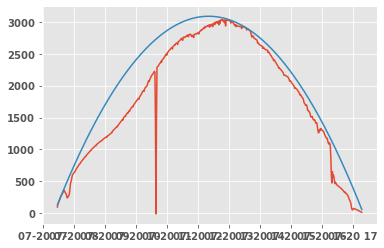

In [251]:
plt.plot(data.index, data['power'])
plt.plot(data.index, data['power_expected'])

plt.show()